In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
from tensorflow.keras import datasets, utils, layers, models, optimizers


# Load the CIFAR-10 dataset. This dataset is a collection of 60,000 32x32 color images
# in 10 different classes (e.g., airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).
# It's automatically split into training and testing sets.
# (x_train, y_train): This contains the training images (x_train) and their corresponding labels (y_train).
# (x_test, y_test): This contains the testing images (x_test) and their corresponding labels (y_test).
# The images are initially represented as pixel intensity values ranging from 0 to 255.
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
NUM_CLASSES = 10

# Perform Data Pre-processing.
#
# Normalize the RGB pixel values.
# Images are typically represented with pixel values ranging from 0 (black) to 255 (white or full color intensity).
# Neural networks generally perform better and train faster when input features are scaled
# to a smaller, consistent range, such as 0 to 1.
# By dividing by 255.0 (using a float to ensure float division), we transform each pixel value
# from its original 0-255 range to a new range between 0.0 and 1.0.
# `.astype('float32')`: We also explicitly convert the data type to float32.
# This is a common practice in deep learning as models often operate with floating-point numbers
# for calculations, and float32 provides a good balance between precision and memory usage.
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Create one-hot encodings for the labels.
# Currently, our `y_train` and `y_test` labels are integers (e.g., 0, 1, 2, ..., 9),
# where each integer represents a specific class.
# For multi-class classification problems with a Softmax output layer (which is typical),
# neural networks expect the labels to be in a "one-hot encoded" format.
#
# In one-hot encoding, we have single integer label in a vector where only one element is "hot" (1)
# and all others are "cold" (0). The position of the '1' corresponds to the class.
#
# Example with NUM_CLASSES = 10:
# - If y_label is 0 (e.g., 'airplane'), it becomes [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
# - If y_label is 1 (e.g., 'automobile'), it becomes [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]
# - If y_label is 9 (e.g., 'truck'), it becomes [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]
#
# `utils.to_categorical()`: This Keras utility function performs this conversion for us.
# - The first argument is the array of integer labels (`y_train` or `y_test`).
# - The second argument, `NUM_CLASSES`, tells the function how long the one-hot vector should be
#   (i.e., the total number of possible classes).
# Practical benefit: This format allows the network's final Softmax layer to directly output
# probabilities for each class, which aligns well with loss functions like `categorical_crossentropy`.
y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

# In this example, we use a convolutional network (with 2D Convolutional Layers) 
# to power the neural network.
#
# Our "Vanilla" neural network had a key limitation - we had to flatten all the 
# pixel data into a single long vector at the very beginning (the Flatten layer).
# During that time, we lost information about spatial relationships between pixels,
# because the network did not know that pixel (1,2) was next to pixel (1,1), or that
# a group of pixels formed a shape.
# 
# Then we passed the pixels into a Dense layer, where every neuron in the current layer is connected
# to every neuron in the previous layer. Dense layers are great at learning complex,
# non-linear relationships between inputs and outputs. However, because they receive a flattened
# input, they essentially treat each pixel as an independent feature.
#
# CNNs (Convolutional Neural Networks) are specifically designed to address the
# limitations of traditional dense networks when dealing with structured data like
# images. They exploit the spatial relationships within the data.
# 
# Conv2D layers layers apply "filters" (also called kernels) that slide across
# the input data (e.g., an image). Each filter is a small matrix of learnable weights.
input_layer = layers.Input(shape=(32, 32, 3))

# Each Conv2D layer is a core feature extraction layer. 
#
# Take this function call: 
# layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same")
# 
# filters = 32: The layer will learn 32 different filters (also called kernels).
# Each filter is designed to detect a specific feature (e.g., a vertical edge, a
# diagonal line, a specific color blob) in the input image.
# 
# kernel_size = 3: Each filter will be a 3x3 matrix. This means it will look at a
# 3x3 patch of the input image at a time.
#
# strides = 1: The filter will move one pixel at a time across the input image.
#
# padding = "same": This ensures that the output feature map has the same spatial
# dimensions (height and width) as the input feature map
x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same")(input_layer)
# Then, the Batch Normalization layer normalizes the activations of the previous
# layer for each batch during training, to remediate gradient explosion. 
#
#  It significantly helps with training stability, speeds up convergence, and can
# act as a mild regularizer, reducing the need for extensive dropout (though dropout
# is still used later). It makes the network less sensitive to the initialization of weights.
x = layers.BatchNormalization()(x)
# Finally, we use a LeakyReLU activation function to introduce non-linearity into the
# network.
x = layers.LeakyReLU()(x)

# Then we do the same, with a stride size of 2 (essentially downsampling the spatial
# dimensions of the feature maps)
x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Then the network learns with 64 different filters, so it's trying to find 
# more diverse or complex patterns. As we go deeper into a CNN, the filters
# tend to learn more abstract and higher-level features by combining the simpler
# features detected by earlier layers.
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Finally, we learn with 64 different filters again, but downsample with a 
# stride size of 2, so the spatial dimensions are halved. 
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Then we take the multi-dimensional output from the last convolutional block and flatten it into a single 1D vector.
# Convolutional layers are excellent at extracting spatial hierarchies of features.
# However, for the final classification decision, these extracted features typically
# need to be fed into a traditional dense neural network layer, which expects a 1D vector as input.
x = layers.Flatten()(x)
x = layers.Dense(128)(x)

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
# Dropouts help prevent overfitting. By randomly "dropping out" neurons, the network cannot rely
# on any single neuron or specific combination of neurons to make predictions. This forces the
# network to learn more robust and generalized features, as it needs to be able to make correct
# predictions even when some information is missing.
x = layers.Dropout(rate = 0.5)(x)

output_layer = layers.Dense(10, activation = "softmax")(x)

model = models.Model(input_layer, output_layer)

# Train the model the same way as before
opt = optimizers.Adam(learning_rate = 0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(x_train,
          y_train,
          batch_size = 32,
          epochs = 10,
          shuffle = True)

model.evaluate(x_test, y_test, batch_size=1000)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.3886 - loss: 1.8057
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5798 - loss: 1.1898
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6475 - loss: 1.0167
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6758 - loss: 0.9227
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7052 - loss: 0.8445
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ -30s -18998us/step - accuracy: 0.7218 - loss: 0.7934
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7389 - loss: 0.7530  
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7493 - loss: 0.7136   
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7648 - loss: 0.6757 
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7777 - loss: 0.6413  
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7168 - loss: 0.8302


[0.8373697400093079, 0.7171000242233276]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


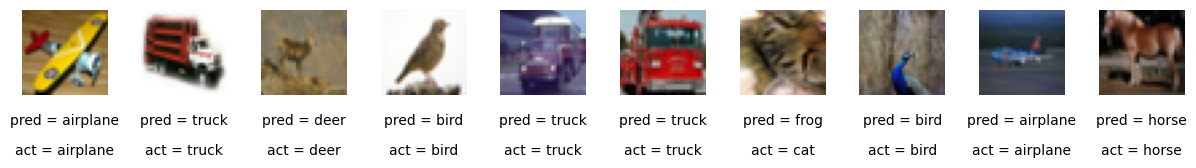

In [9]:
import matplotlib.pyplot as plt

# Define the human-readable names for each of the 10 CIFAR-10 classes.
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Use the trained model # to make predictions on the test dataset (x_test).
# The `model.predict()` method outputs a probability distribution for each image
# over the 10 classes.
# For example, for one image, the output might look like [0.01, 0.05, 0.88, ..., 0.02],
# where 0.88 is the probability of it being a 'bird'.
# This `predictions` array will have a shape of [number_of_test_images, NUM_CLASSES].
# For CIFAR-10, x_test has 10,000 images, so `predictions` will be [10000, 10].
predictions = model.predict(x_test)

# The `predictions` array contains probabilities (e.g., [0.01, 0.05, 0.88, ...]).
# To get the final predicted class for each image, we need to find the class
# with the highest probability.
#   - `np.argmax()`: This NumPy function returns the *index* of the maximum value along a given axis.
#   - `axis = -1`: This specifies that the operation should be performed along the *last* axis.
#                  In our `predictions` array (shape [10000, 10]), the last axis is the
#                  class probabilities dimension (the 10 possibilities).
#                  So, for each of the 10,000 observations, it finds the index (0-9)
#                  corresponding to the highest probability.
# `preds_single` will be an array of strings like ['bird', 'horse', 'airplane', ...],
# representing the model's predicted class for each test image.
preds_single = CLASSES[np.argmax(predictions, axis = -1)]
# Do the same for the actual (true) labels.
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

## Visualize the results
N_TO_SHOW = 10
# Randomly select `n_to_show` indices from the range of available test images.
# This ensures we pick a diverse set of images to display.
indices = np.random.choice(range(0, len(x_test)), N_TO_SHOW)

# Create a figure for plotting.
# `figsize = (15, 3)` sets the width of the figure to 15 inches and height to 3 inches.
fig = plt.figure(figsize = (15, 3))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

# Loop through the randomly selected indices to display each image and its predictions.
for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, N_TO_SHOW, i + 1)
    # Turn off the axes (ticks and labels) for a cleaner image display.
    ax.axis('off')
    # Add text for the predicted label below the image.
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize = 10, ha = 'center', transform = ax.transAxes)
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize = 10, ha = 'center', transform = ax.transAxes)
    ax.imshow(img)

plt.show()